In [356]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import random
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.feature_extraction import FeatureHasher
from sklearn import metrics
from sklearn.linear_model import HuberRegressor, Ridge, Lasso
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble

# EDA

In [137]:
df = pd.read_csv('wine_description.csv')

In [138]:
years_df = pd.read_csv('years.csv',header = None)

In [139]:
df = pd.concat([df,years_df],axis = 1)

In [140]:
df = df.rename(columns = {1:'years'})

In [142]:
df.dropna(subset = ['price','province'], inplace =True)
df = df[df['price'] < 150]

In [143]:
data_new = shuffle(df) 

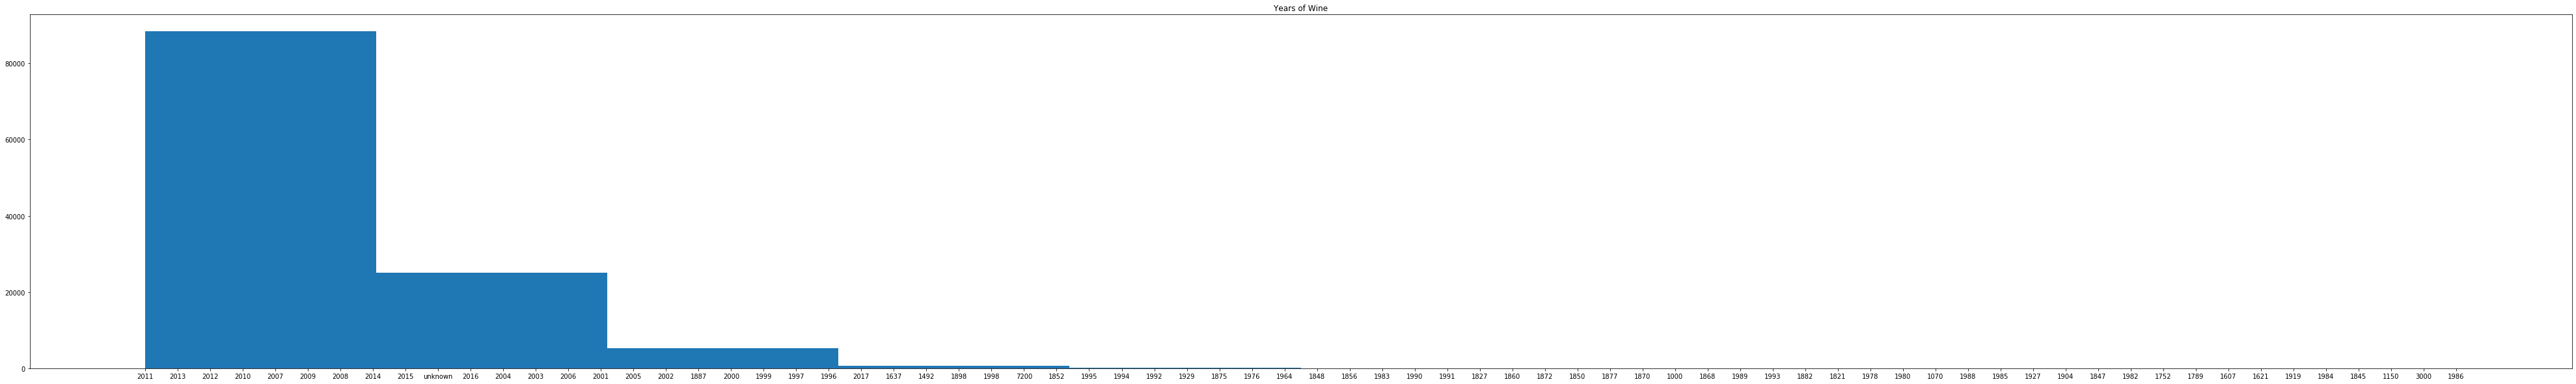

In [202]:
fig, ax = plt.subplots(figsize = (70,10))
ax.hist(df['years'])
ax.set_title('Years of Wine')
plt.show()

In [144]:
X = data_new.drop(columns=['price','Unnamed: 0','taster_twitter_handle','winery','country','description','title',
                     'region_2','taster_name',0])
y = data_new['price']

In [173]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [174]:
# region_1
# Due to one winery could have severl corresponding country or province and and the same reason 
# when use country to predict province. The result is pretty bad we decide to randomly choose 
# Get all regions in different province and if province is not missing, randomly choose region from that province. 
train_x = train_x.fillna('0')
province = train_x['province'].unique()
dict_c={}


for i in province:
    tmp = train_x[train_x['province'] == i].region_1.unique()


    if np.mean(tmp==['0']) == 1:
            
        dict_c[i] = [i]
        
    else:
        dict_c[i] = tmp.tolist()
        
for i in range(train_x.shape[0]):
    while train_x.iloc[i,3] == '0':
        r = dict_c[train_x.iloc[i,2]]
        t = random.choice(r)
        train_x.iloc[i,3]= t
       
     

In [227]:
# for test same ways to do it. 

test_x = test_x.fillna('0')
province = test_x['province'].unique()
dict_c={}


for i in province:
    tmp = test_x[test_x['province'] == i].region_1.unique()


    if np.mean(tmp==['0']) == 1:
            
        dict_c[i] = [i]
        
    else:
        dict_c[i] = tmp.tolist()
        
for i in range(test_x.shape[0]):
    while test_x.iloc[i,3] == '0':
        r = dict_c[test_x.iloc[i,2]]
        t = random.choice(r)
        test_x.iloc[i,3]= t

In [175]:
data = train_x.drop(columns = 'province')

In [177]:
labels = data.columns


In [186]:
data['years'][data['years'] == 'unknown']='0'

C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [188]:
n = len(data)
for label in labels:
  num = sum(data[label]=='0')
  print(label + ': ' + str(num) + '  ' +str(num/n*100) + '%'  )

designation: 27519  28.798819540374232%
points: 0  0.0%
region_1: 0  0.0%
variety: 1  0.0010465067604336724%
years: 3309  3.462890870275022%


In [195]:
for label in labels:
  num_unique = len(np.unique(list(data[label])))

  print(label + ': ' + str(num_unique))

designation: 30696
points: 21
region_1: 1486
variety: 664
years: 69


In [218]:


train_x


,designation,points,province,region_1,variety,years
59975,0,96,Tuscany,Brunello di Montalcino,Sangiovese,2012
123460,La Florencia,81,Mendoza Province,Luján de Cuyo,Torrontés,2011
73922,Pét Nat Rosé,88,Weinland Österreich,Weinland Österreich,Sparkling Blend,2015
87236,L'Entente Blanc,90,Washington,Yakima Valley,Marsanne,2010
4212,0,87,Lisboa,Lisboa,Arinto,2015
...,...,...,...,...,...,...
48708,0,91,Rhône Valley,Côtes du Rhône,Rhône-style Red Blend,2012
126465,Serrig Schloss Saarsteiner Auslese Grosse Lage,93,Mosel,Mosel,Riesling,2014
109732,Empyrée,89,Southwest France,Cahors,Malbec,2007
73626,0,92,Piedmont,Barolo,Nebbiolo,2010


# Function we used in our model

In [216]:
def hash_f(features,n ,data):
    fh = FeatureHasher(n_features=n, input_type='string')
    hashed_features = fh.fit_transform(data)
    hashed_features = hashed_features.toarray()
    return hashed_features

In [232]:
def vectorize(features,n):
    train_vals_features = hash_f(features,n,train_x.loc[:,features])
    test_vals_features = hash_f(features,n,test_x.loc[:,features])



    return  train_vals_features,test_vals_features

In [239]:
def MSE(y,pred):
    mse = ((y-pred)**2).sum()/len(y)
    return mse

In [258]:
def show_error(y_true, y_pred):
    print('MSE = ' , MSE(y_true, y_pred),'R2 score = ', r2_score(y_true, y_pred),'Explained Variance score = ',
          metrics.explained_variance_score(y_true, y_pred),'MAE score = ', metrics.mean_absolute_error(y_true, y_pred))

    
  
    

In [ ]:
Xtrain_rawpoints = np.vstack((train_vals_features.T,np.ones(len(train_vals_features)))).T
Xtest_rawpoints = np.vstack((test_vals_features.T,np.ones(len(test_vals_features)))).T

# Encoding our categorical features 

In [233]:
# Designation #40
vtrain_designation, vtest_designation = vectorize('designation',40)
# region_1 # 60
vtrain_region_1, vtest_region_1 = vectorize('region_1',40)
# variety #40
vtrain_variety, vtest_variety = vectorize('variety',40)
# years
vtrain_years, vtest_years = vectorize('years',20)

In [234]:
Xtrain_rawpoints = np.vstack((vtrain_designation.T,vtrain_region_1.T,vtrain_variety.T,vtrain_years.T,np.ones(len(vtrain_years)))).T
Xtest_rawpoints = np.vstack((vtest_designation.T,vtest_region_1.T,vtest_variety.T,vtest_years.T,np.ones(len(vtest_years)))).T

# Linear Model

Lstsq

In [260]:
wd_b,resid,rank,s = np.linalg.lstsq(Xtrain_rawpoints,train_y)

pred_test_rawpoints = np.dot(Xtest_rawpoints,wd_b)
pred_train_rawpoints = np.dot(Xtrain_rawpoints,wd_b)

show_error(train_y,pred_train_rawpoints)
show_error(test_y,pred_test_rawpoints)

C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


MSE =  377.5864147736427 R2 score =  0.23301349325137488 Explained Variance score =  0.23301350109793806 MAE score =  13.763920151382631
MSE =  383.4876472033991 R2 score =  0.23528825381166796 Explained Variance score =  0.23530351735423283 MAE score =  13.851060471080734


In [320]:
# Huber regression
huber_r = HuberRegressor().fit(Xtrain_rawpoints, train_y)
pred_train_rawpoints = huber_r.predict(Xtrain_rawpoints)
pred_test_rawpoints = huber_r.predict(Xtest_rawpoints)

show_error(train_y,pred_train_rawpoints)
show_error(test_y,pred_test_rawpoints)

MSE =  396.56984289906796 R2 score =  0.1944526958965176 Explained Variance score =  0.2208475383019649 MAE score =  13.214822037954535
MSE =  403.15757206762174 R2 score =  0.19606450644977458 Explained Variance score =  0.22320588905706995 MAE score =  13.299104516454335


In [327]:
# Lasso
lasso = linear_model.Lasso()
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]}
lasso_regressor = GridSearchCV(lasso,parameters, scoring = 'r2', cv=5)
lasso_regressor.fit(Xtrain_rawpoints, train_y)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

C:\YZC\Conda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2062531.1307050437, tolerance: 3767.9874932591188
  positive)
C:\YZC\Conda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3414809.5805969704, tolerance: 3756.696616461506
  positive)
C:\YZC\Conda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4758629.883372109, tolerance: 3759.2577075492177
  positive)
C:\YZC\Conda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2086103.4142040573, tolerance: 3758.57691314

{'alpha': 0.001}
0.23084568755312057


As we can see this model is similar to oridnary least square with same r2

In [330]:
# Ridge
ridge = linear_model.Ridge()
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]}
ridge_regressor = GridSearchCV(ridge,parameters, scoring = 'r2', cv=5)
ridge_regressor.fit(Xtrain_rawpoints, train_y)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

#Similar to above

C:\YZC\Conda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.40243e-17): result may not be accurate.
  overwrite_a=True).T
C:\YZC\Conda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.81085e-17): result may not be accurate.
  overwrite_a=True).T
C:\YZC\Conda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.64909e-17): result may not be accurate.
  overwrite_a=True).T
C:\YZC\Conda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.0922e-17): result may not be accurate.
  overwrite_a=True).T
C:\YZC\Conda\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.90868e-17): result may not be accurate.
  overwrite_a=True).T


{'alpha': 10}
0.2308713202391016


# Decision Tree


In [340]:
# Decision tree regressor
param_grid = {'criterion':['gini','entropy'], 'max_depth': np.arange(3, 10)}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5)
clf = clf.fit(Xtrain_rawpoints, train_y)
pred_test_rawpoints = clf.predict_proba(Xtest_rawpoints)
pred_train_rawpoints = clf.predict_proba(Xtrain_rawpoints)


C:\YZC\Conda\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [343]:
clf.best_params_



{'criterion': 'gini', 'max_depth': 9}

In [348]:
clf = tree.DecisionTreeRegressor(max_depth = 9)
clf = clf.fit(Xtrain_rawpoints, train_y)
pred_test_rawpoints = clf.predict(Xtest_rawpoints)
pred_train_rawpoints = clf.predict(Xtrain_rawpoints)
show_error(train_y,pred_train_rawpoints)
show_error(test_y,pred_test_rawpoints)


MSE =  313.7142105976125 R2 score =  0.36275629342250004 Explained Variance score =  0.36275629342250004 MAE score =  12.280363139481247
MSE =  332.8358104552673 R2 score =  0.33629295320623787 Explained Variance score =  0.3362940002274245 MAE score =  12.561245387996752


In [355]:
# Random Forest
regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(Xtrain_rawpoints, train_y)
pred_test_rawpoints = regr.predict(Xtest_rawpoints)
pred_train_rawpoints = regr.predict(Xtrain_rawpoints)
show_error(train_y,pred_train_rawpoints)
show_error(test_y,pred_test_rawpoints)

C:\YZC\Conda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MSE =  286.30067104755966 R2 score =  0.41844106944844617 Explained Variance score =  0.4184422797436045 MAE score =  11.734635373662963
MSE =  308.70888154437284 R2 score =  0.38440440105119544 Explained Variance score =  0.38441006729967986 MAE score =  12.073082375332415


In [358]:
#GBR regression 

params = {'max_depth': 9, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(Xtrain_rawpoints, train_y)
pred_test_rawpoints = clf.predict(Xtest_rawpoints)
pred_train_rawpoints = clf.predict(Xtrain_rawpoints)
show_error(train_y,pred_train_rawpoints)
show_error(test_y,pred_test_rawpoints)

MSE =  185.13815612090085 R2 score =  0.62393120601498 Explained Variance score =  0.62393120601498 MAE score =  9.320126768894504
MSE =  230.39330962939226 R2 score =  0.5405732846895206 Explained Variance score =  0.5405754388142654 MAE score =  10.141495351963998


In [360]:
# a little overfitting, i decide to decrease the max_steps
params = {'max_depth': 5, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(Xtrain_rawpoints, train_y)
pred_test_rawpoints = clf.predict(Xtest_rawpoints)
pred_train_rawpoints = clf.predict(Xtrain_rawpoints)
show_error(train_y,pred_train_rawpoints)
show_error(test_y,pred_test_rawpoints)

MSE =  277.08390420816755 R2 score =  0.4371629713100367 Explained Variance score =  0.4371629713100367 MAE score =  11.47421918308544
MSE =  289.72514873004195 R2 score =  0.4222598145840334 Explained Variance score =  0.42227517676907955 MAE score =  11.621998541994833


In [361]:
params = {'max_depth': 5, 'loss': 'huber'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(Xtrain_rawpoints, train_y)
pred_test_rawpoints = clf.predict(Xtest_rawpoints)
pred_train_rawpoints = clf.predict(Xtrain_rawpoints)
show_error(train_y,pred_train_rawpoints)
show_error(test_y,pred_test_rawpoints)

MSE =  293.09727291852636 R2 score =  0.40463521806499814 Explained Variance score =  0.4130050361665033 MAE score =  11.133087256361092
MSE =  304.233624759891 R2 score =  0.3933284992725058 Explained Variance score =  0.4024654295698047 MAE score =  11.274916679969122


In [363]:
params = {'max_depth': 5, 'loss': 'quantile'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(Xtrain_rawpoints, train_y)
pred_test_rawpoints = clf.predict(Xtest_rawpoints)
pred_train_rawpoints = clf.predict(Xtrain_rawpoints)
show_error(train_y,pred_train_rawpoints)
show_error(test_y,pred_test_rawpoints)

MSE =  705.8887535004576 R2 score =  -0.4338628934121549 Explained Variance score =  0.3417994827774876 MAE score =  22.66227267035545
MSE =  710.415137393607 R2 score =  -0.4166370265030894 Explained Variance score =  0.33556417899589897 MAE score =  22.75976168171035
